In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd

import torch.nn as nn
from torch import autograd
from torch.autograd import Variable
# from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import copy

# 用于翻转图像
from scipy import misc, ndimage

In [2]:
# 检查cuda是否可用
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('using cuda:',torch.cuda.get_device_name(0))
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

using cuda: NVIDIA GeForce RTX 3090


device(type='cuda')

In [3]:
all_labels=['autumn', 'beach', 'champaign', 'city', 'classical', 'CNU','desert', 'dreamlike', 'flowers', 'food', 
         'forest', 'fresh','fruit', 'garden', 'lake', 'mountains', 'nature', 'night','oil', 'pixiv','scenery', 
         'sea', 'sky', 'spring','stars', 'summer', 'technology', 'universe', 'watercolor','winter','dangjian']

In [4]:
# 需要更改的变量们

k = 12
# 配色方案数据文件
dataset_path = './training_data.xlsx'

template_path = './template_data.xlsx'

# 权重大小
w1 = 0.6
w2 = 0.4

# 批大小
batch_size = 100

# 循环次数
num_epochs = 10

n_critic = 2    # G每训练一次，D的训练次数
display_step = 50     # 每训练完多少个batch展示一次效果

# 过程生成方案的图片保存路径文件夹
process_schemes_path = './process_imgs/'

In [5]:
# 自定义数据集类

class MyDataset(torch.utils.data.Dataset):   #继承Dataset
    def __init__(self,file_path):
        
        self.data_df = pd.read_excel(file_path)
        
        self.device = device
        
        # 颜色数据
        self.color_data = self.data_df[['color1-R','color1-G','color1-B',
                                        'color2-R','color2-G','color2-B',
                                        'color3-R','color3-G','color3-B',
                                        'color4-R','color4-G','color4-B',
                                        'color5-R','color5-G','color5-B',
                                        'color6-R','color6-G','color6-B',
                                        'color7-R','color7-G','color7-B',
                                        'color8-R','color8-G','color8-B',
                                        'color9-R','color9-G','color9-B',
                                        'color10-R','color10-G','color10-B',
                                        'color11-R','color11-G','color11-B',
                                        'color12-R','color12-G','color12-B'
                                       ]]
        
    def __getitem__(self,index):
        label = self.data_df.iloc[index,1]
        # label独热编码
        target = torch.zeros((31)).to(self.device)
        label_index = all_labels.index(label)
        target[label_index] = 1.0
        
        # color data , normalised from 0-255 to -1~1
        color_values = torch.FloatTensor((self.color_data.iloc[index,:].values/255)*2-1).to(self.device)
        
        # return label, color_values tensor and target tensor
        return label, color_values, target
    
    def __len__(self):
        return len(self.data_df)
    
    def show_colors(self,index):
        # 提取颜色RGB值
        colors_rgb = np.array(self.color_data.iloc[index,:]).reshape(-1,3)   # 每一行表示一个颜色
        img = []
        result_width_per_center = 15
        result_height = 20
        n_channels = 3
        for color_index in range(k):
            img.append(
                np.full((result_width_per_center * result_height, n_channels), colors_rgb[color_index,:],
                        dtype=int))
        img = np.array(img)
        img = img.reshape((result_width_per_center * k, result_height , n_channels))
        img = img.astype(np.uint8)
        
        # 翻转图像
        img_rote = ndimage.rotate(img,90)
        
        print('label:',self.data_df.iloc[index,1])
        plt.axis('off')
        plt.imshow(img_rote, interpolation='none')

In [6]:
# 加载数据
data_dataset = MyDataset(dataset_path)

# data_loader = torch.utils.data.DataLoader(dataset = data_dataset, batch_size=batch_size, shuffle=True,
#                                          num_workers = 0) #多线程加载数
data_loader = torch.utils.data.DataLoader(dataset = data_dataset, batch_size=batch_size, shuffle=True, 
                                          num_workers = 0)

In [7]:
# 定义判别器

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(3*k+31, 512),
            nn.LeakyReLU(0.05,inplace=True),
            # nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.05,inplace=True),
            # nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.05,inplace=True),
            # nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input_data, labels):
        input_data = torch.cat([input_data, labels],1)  # 1表示按列合并（左右合并）
        output = self.model(input_data)
        return output.squeeze()

In [8]:
# 定义生成器

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100+31, 256),
            nn.LeakyReLU(0.02,inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.02,inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.02,inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 3*k),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        x = torch.cat([z, labels],1)
        output = self.model(x)
        return output

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# 训练
generator = Generator().cuda()
discriminator = Discriminator().cuda()

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [10]:
# 实例化summarywriter，并指明日志存放路径。支持自动创建
# writer = SummaryWriter(log_dir)

In [11]:
# 随机独热编码
def one_hot(batch_size):
    code = torch.zeros(batch_size,31)
    for i in range(batch_size):
        code[i][np.random.randint(0, 31)] = 1.0     # [0,31)之间随机挑选一个整数作为索引
    return code

In [12]:
# 过程测试独热编码
# 每种主题生成5个方案
def test_one_hots():
    code = torch.zeros(31*5,31)
    for i in range(0,31):
        code[i*5][i] = 1.0
        code[i*5+1][i] = 1.0
        code[i*5+2][i] = 1.0
        code[i*5+3][i] = 1.0
        code[i*5+4][i] = 1.0

    return code

In [13]:
# 模板方案
template_schemes = pd.read_excel(template_path)

# template_list里面有31个tensor，每个tensor存储的是每个主题的25个模板方案
template_list = []
for theme in all_labels:
    data_one_theme = template_schemes[template_schemes['label']==theme]
    tensor_one_theme = torch.FloatTensor((data_one_theme.iloc[:,2:].values/255)*2-1).cuda()
    template_list.append(tensor_one_theme)

def tanh(x):
    return torch.tanh(x)
    
def template_distance(fake_labels,fake_images):
    min_list = []
    for i in range(31):
        # 提取该主题的模板tensor
        theme_template = template_list[i]
        # 提取该主题的生成图像
        true_index = torch.where(fake_labels[:,i] == 1.0)# 是一个元组，记录了第几行fake_images是该主题的
        true_index_list = true_index[0].cpu().numpy().tolist()
        if len(true_index_list)!=0:
            theme_generate_scheme = fake_images[true_index_list]
            # 计算欧氏距离
            dist = torch.cdist(theme_generate_scheme,theme_template.contiguous(),p=2)
            # dist每一行代表每个生成方案与25个模板的25个距离，取最小值
            for j in range(len(true_index_list)):
                min_list.append(dist[j].min())
            
#     print(len(min_list))
    # 一个batch100个生成方案的最小距离平均值作为distance_loss
    distance_loss = sum(min_list)/len(min_list)
    return distance_loss

In [14]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, loss_fn):
    
    g_optimizer.zero_grad()
    
    z = Variable(torch.rand(batch_size, 100).squeeze()).cuda()  # （行数，列数）
    fake_labels = Variable(one_hot(batch_size)).cuda()
#     print(fake_labels)
#     print(fake_labels.size())
    
    fake_images = generator(z, fake_labels)
#     print(fake_images)
#     print(fake_images.size())
    
    g_loss_distance = template_distance(fake_labels,fake_images)
    
    validity = discriminator(fake_images, fake_labels)
#     print('validity_g:',validity)
    
    g_loss_discriminator = loss_fn(validity, Variable(torch.ones(batch_size)).cuda())
#     print('target_g:',Variable(torch.ones(batch_size)))
    # g_loss = w1*g_loss_discriminator + w2*g_loss_distance
    g_loss = g_loss_discriminator + g_loss_distance
    
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss.item()

In [15]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
#     print('real_validity_d:',real_validity)
    real_loss_discriminator = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
#     print('real_target_d:',Variable(torch.ones(batch_size)))

    real_loss_distance = template_distance(labels,real_images)
    
    real_loss =  w1*real_loss_discriminator + w2*real_loss_distance
    
    # train with fake images
    z = Variable(torch.rand(batch_size, 100).squeeze()).cuda()
    fake_labels = Variable(one_hot(batch_size)).cuda()
    
    fake_images = generator(z, fake_labels)
    
    fake_validity = discriminator(fake_images, fake_labels)
#     print('fake_validity_d:',fake_validity)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
#     print('fake_target_d:',Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [16]:
%%time

D_loss_step = []                          # 记录训练过程中判别器loss变化
G_loss_step = []                          # 记录训练过程中生成器loss变化
Step_list = []
progress_schemes = []

D_loss_all = []  
G_loss_all = []  

D_loss_epoch = []  
G_loss_epoch = [] 

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    # i表示第i-1个batch（i为索引）
    for (index, data) in enumerate(data_loader):
        
        # step标示当下累计加载了多少个batch
        step = epoch * len(data_loader) + index + 1
        # print('batch:',index)
        
        images = data[1]
        labels = data[2]
        
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # model.train():在训练开始之前加上这一句，作用是启用batch normalization和dropout
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, loss_fn,
                                              real_images, labels)
        # print('dloss:','\n',d_loss)
        
        g_loss = 0
        for _ in range(n_critic):
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, loss_fn)
        # print('gloss:','\n',g_loss)
        
        # 记录损失值
        # writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)
        D_loss_all.append(d_loss)
        G_loss_all.append(g_loss)
        
        if (step == 1) or (step % display_step == 0):
            # model.eval（）作用是不启用batch normalization和dropout
            generator.eval()
            
            D_loss_step.append(d_loss)
            G_loss_step.append(g_loss)
            Step_list.append(step)
            
            # 测试模型输出
            z = Variable(torch.rand(31*5, 100).squeeze()).cuda()
            labels = Variable(test_one_hots()).cuda()
            
            sample_schemes = generator(z, labels).unsqueeze(1)
            
            progress_schemes.append(sample_schemes)
            
    
    D_loss_epoch.append(d_loss)
    G_loss_epoch.append(g_loss)
    
    print('Done!')
    
# print('D_loss: ',D_loss_step)
# print('G_loss: ',G_loss_step)

# print('progress_schemes: ',progress_schemes)

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
CPU times: user 9min 41s, sys: 593 ms, total: 9min 41s
Wall time: 9min 41s


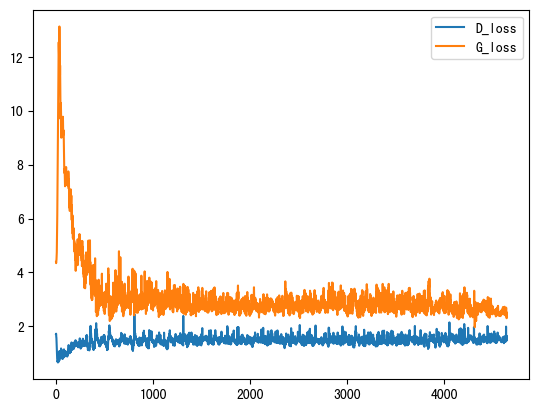

In [17]:
plt.plot(D_loss_all,label = 'D_loss')
plt.plot(G_loss_all,label = 'G_loss')
plt.legend()

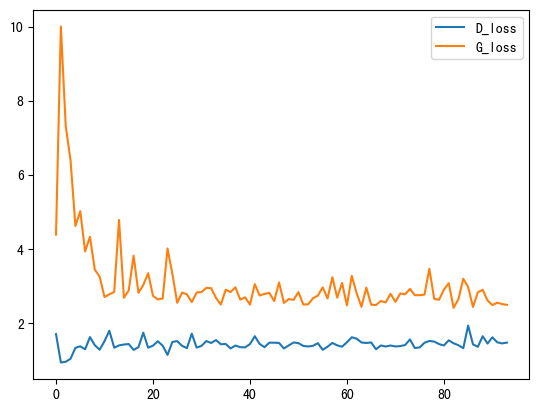

In [18]:
plt.plot(D_loss_step,label = 'D_loss')
plt.plot(G_loss_step,label = 'G_loss')
plt.legend()

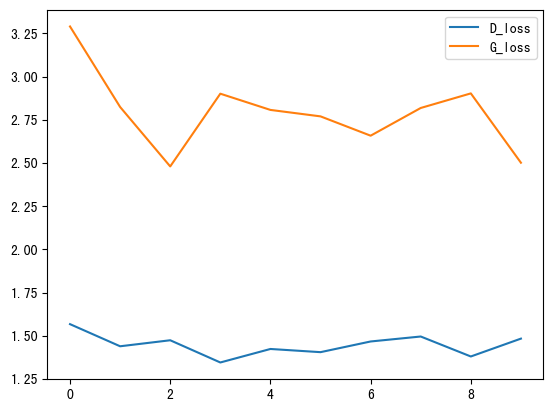

In [19]:
plt.plot(D_loss_epoch,label = 'D_loss')
plt.plot(G_loss_epoch,label = 'G_loss')
plt.legend()

In [20]:
# # 过程方案输出
# progress_schemes

In [21]:
len(progress_schemes)

94

In [22]:
# 这个函数生成单张图像
def create_image(scheme_rgb):
    img = []
    result_width_per_center = 40
    result_height = 60
    n_channels = 3

    for color_index in range(k):
        img.append(
            np.full((result_width_per_center * result_height, n_channels), scheme_rgb[color_index,:],
                    dtype=int))
    img = np.array(img)
    img = img.reshape((result_width_per_center * k, result_height , n_channels))
    img = img.astype(np.uint8)

    # 翻转图像
    img_rote = ndimage.rotate(img,90)

    return img_rote

# 这个函数用于显示并保存过程方案
# 传进来的schemes_list是每一次记录的5*31个方案列表

def process_schemes_show(schemes_list,process_step):
    
    theme_index = 0
    for scheme_index in range(1,5*31+1):
        # 提取颜色RGB值
        scheme_rgb = np.array(schemes_list[scheme_index-1]).reshape(-1,3)   # 每一行表示一个颜色
        # label
        label = all_labels[theme_index]
        
        if scheme_index % 5 == 0:
            theme_index += 1
        
        plt.subplot(31,5,scheme_index)
        plt.imshow(create_image(scheme_rgb))
        plt.axis('off')
        plt.title(label,fontsize = 5)
        
#     plt.show()
    plt.savefig(process_schemes_path+str(process_step)+'_batches.jpg')
    
    print(str(process_step)+'_batches.jpg  处理完成')
    
    plt.clf()

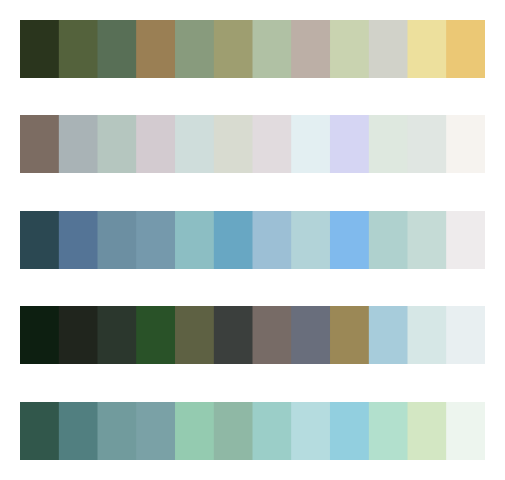

<Figure size 640x480 with 0 Axes>

In [56]:
# 单个方案生成测试
test_theme = 'beach'

n = 5   # 生成5个方案出来

theme_index = all_labels.index(test_theme)

label_code = torch.zeros(n,31).cuda()
for i in range(n):
    label_code[i][theme_index] = 1.0

trandom_z = Variable(torch.rand(n, 100)).cuda()

output_schemes = generator(trandom_z, label_code)

def test_schemes_show(schemes_list,n):
    
    for scheme_index in range(1,n+1):
        # 提取颜色RGB值
        scheme_rgb = np.array(schemes_list[scheme_index-1]).reshape(-1,3)   # 每一行表示一个颜色
        
        plt.subplot(n,1,scheme_index)
        plt.imshow(create_image(scheme_rgb))
        plt.axis('off')
        
    plt.show()
    plt.clf()
    
import warnings
warnings.filterwarnings('ignore')
    
# 创建画布
plt.figure(figsize=(3,3),dpi=200)

# 设置子图行列间距
plt.tight_layout()
    
# -0~1放缩至0~1，再放缩至0~255
output_schemes_rgb = np.around(((output_schemes.detach()+1)/2*255).cpu().numpy() , 0)

test_schemes_show(output_schemes_rgb,n)

In [57]:
# progress_schemes里面是若干个tensor，每一个tensor大小为[155, 1, 21]，记录的是每一次记录下的5*31个配色方案，
# 每个配色方案由（3*k）个变量表示

# 创建画布
plt.figure(figsize=(5,15),dpi=200,clear = True)
# 设置子图行列间距
plt.tight_layout()

# 遍历每一次记录的150个方案
for index in range(len(progress_schemes)):
    
    progress_schemes_tensor_ = torch.squeeze(progress_schemes[index])  # 降维为[155, 21]
    
    # process_step表示的是此次记录时已经训练了多少个batch
    process_step = Step_list[index]
    
    # -0~1放缩至0~1，再放缩至0~255
    schemes_list_rgb = np.around(((progress_schemes_tensor_.detach()+1)/2*255).cpu().numpy() , 0)

    process_schemes_show(schemes_list_rgb,process_step)

1_batches.jpg  处理完成
50_batches.jpg  处理完成
100_batches.jpg  处理完成
150_batches.jpg  处理完成
200_batches.jpg  处理完成
250_batches.jpg  处理完成
300_batches.jpg  处理完成
350_batches.jpg  处理完成
400_batches.jpg  处理完成
450_batches.jpg  处理完成
500_batches.jpg  处理完成
550_batches.jpg  处理完成
600_batches.jpg  处理完成
650_batches.jpg  处理完成
700_batches.jpg  处理完成
750_batches.jpg  处理完成
800_batches.jpg  处理完成
850_batches.jpg  处理完成
900_batches.jpg  处理完成
950_batches.jpg  处理完成
1000_batches.jpg  处理完成
1050_batches.jpg  处理完成
1100_batches.jpg  处理完成
1150_batches.jpg  处理完成
1200_batches.jpg  处理完成
1250_batches.jpg  处理完成
1300_batches.jpg  处理完成
1350_batches.jpg  处理完成
1400_batches.jpg  处理完成
1450_batches.jpg  处理完成
1500_batches.jpg  处理完成
1550_batches.jpg  处理完成
1600_batches.jpg  处理完成
1650_batches.jpg  处理完成
1700_batches.jpg  处理完成
1750_batches.jpg  处理完成
1800_batches.jpg  处理完成
1850_batches.jpg  处理完成
1900_batches.jpg  处理完成
1950_batches.jpg  处理完成
2000_batches.jpg  处理完成
2050_batches.jpg  处理完成
2100_batches.jpg  处理完成
2150_batches.jpg  处理完成
2200_batche

<Figure size 1000x3000 with 0 Axes>

In [60]:
# 存储生成器
torch.save(generator, './generator_model.pt')
